<a href="https://colab.research.google.com/github/IlyaTrofimov/ML2020-Skoltech/blob/master/seminar-03-ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Measure quality of a classification model

This notebook explains how to measure quality of a classification machine learning model.
We provide definitions for various quality measures and try to find out if they are suitable or not for a particular machine learning classification problem.

The data is a subsample from the kaggle comptetion "Give me some credit"
https://www.kaggle.com/c/GiveMeSomeCredit#description

In [0]:
# Imports

# data processing tools: pandas and numpy
import numpy as np
import pandas as pd

# visualization tools: matplotlib, seaborn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning tools: various methods from scikit-learn
from sklearn.tree import DecisionTreeClassifier
base_classifier = DecisionTreeClassifier()

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.metrics import f1_score, accuracy_score, average_precision_score

# Load data

In [0]:
!git clone https://github.com/IlyaTrofimov/ML2020-Skoltech.git

Cloning into 'ML2020-Skoltech'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 69 (delta 24), reused 18 (delta 4), pack-reused 0
Unpacking objects: 100% (69/69), done.


In [0]:
!ls ML2020-Skoltech/credit

cs-test.csv  cs-training.csv  test_data.csv  training_data.csv


In [0]:
# load the data
training_data = pd.read_csv('ML2020-Skoltech/credit/training_data.csv')
test_data = pd.read_csv('ML2020-Skoltech/credit/test_data.csv')

See some technical info about data

In [0]:
# print information about the data
training_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 11 columns):
SeriousDlqin2yrs                        5001 non-null int64
RevolvingUtilizationOfUnsecuredLines    5001 non-null float64
age                                     5001 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    5001 non-null int64
DebtRatio                               5001 non-null float64
MonthlyIncome                           4031 non-null float64
NumberOfOpenCreditLinesAndLoans         5001 non-null int64
NumberOfTimes90DaysLate                 5001 non-null int64
NumberRealEstateLoansOrLines            5001 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    5001 non-null int64
NumberOfDependents                      4859 non-null float64
dtypes: float64(4), int64(7)
memory usage: 429.9 KB


Let's look at some general statistics of data:
* **count** -- number of not `NaN` values;
* **mean**, **std** -- mean and standard deviation;
* other -- minimal, maximal values, quantiles.

In [0]:
training_data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,5001.0,0.060988,0.239332,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,5001.0,3.842957,117.415101,0.0,0.030053,0.163463,0.556134,6324.0
age,5001.0,52.128374,14.907257,21.0,41.000000,52.000000,63.000000,99.0
NumberOfTime30-59DaysPastDueNotWorse,5001.0,0.355729,3.178306,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,5001.0,368.032252,2593.676885,0.0,0.177007,0.365727,0.829553,168835.0
MonthlyIncome,4031.0,6554.690151,7058.453424,0.0,3454.500000,5333.000000,8167.500000,208333.0
NumberOfOpenCreditLinesAndLoans,5001.0,8.383323,5.111950,0.0,5.000000,8.000000,11.000000,46.0
NumberOfTimes90DaysLate,5001.0,0.194361,3.132956,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,5001.0,1.022795,1.107556,0.0,0.000000,1.000000,2.000000,17.0
NumberOfTime60-89DaysPastDueNotWorse,5001.0,0.165167,3.111899,0.0,0.000000,0.000000,0.000000,98.0


Choose randomly ten objects from dataset:

In [0]:
training_data.sample(10, random_state=123)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
2648,0,0.000000,57,0,0.000000,8500.0,3,0,0,0,3.0
2456,0,0.265081,32,0,0.207063,6200.0,6,0,0,0,3.0
4558,0,0.067098,34,0,0.280673,8500.0,7,0,2,0,2.0
4885,0,1.123876,26,1,0.356159,2540.0,5,3,0,3,2.0
92,0,0.784836,52,0,2662.000000,NaN,10,0,2,1,0.0
3602,0,0.004000,70,0,0.169479,8000.0,8,0,1,0,1.0
30,0,0.704074,28,1,0.155201,4200.0,8,0,0,0,0.0
1746,0,0.142398,57,0,0.264080,4225.0,6,0,1,0,0.0
1692,0,0.016862,48,0,0.425822,12260.0,12,0,5,0,4.0
2277,1,0.935497,55,0,0.450293,6477.0,10,0,2,0,0.0


We see that there are `NaN`s in data. Let's calculate mean values of features on **training data** and fill them in instead of the missing values. We will do that both for **train** and **test**.

There are several ways to fill in skipped data:
* mean, median;
* regression predictions;
* in case of time series -- last known value,
* linear interpolation, etc.

If the number of skipped values is small, you can throw the corresponding objects away.

In [0]:
training_data["SeriousDlqin2yrs"].value_counts()

0    4696
1     305
Name: SeriousDlqin2yrs, dtype: int64

In [0]:
# fill NA values with mean training values
train_mean = training_data.mean()

training_data.fillna(train_mean, inplace=True)
test_data.fillna(train_mean, inplace=True)

print(training_data.isnull().sum())
print(test_data.isnull().sum())

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64


Compare train and test distributions

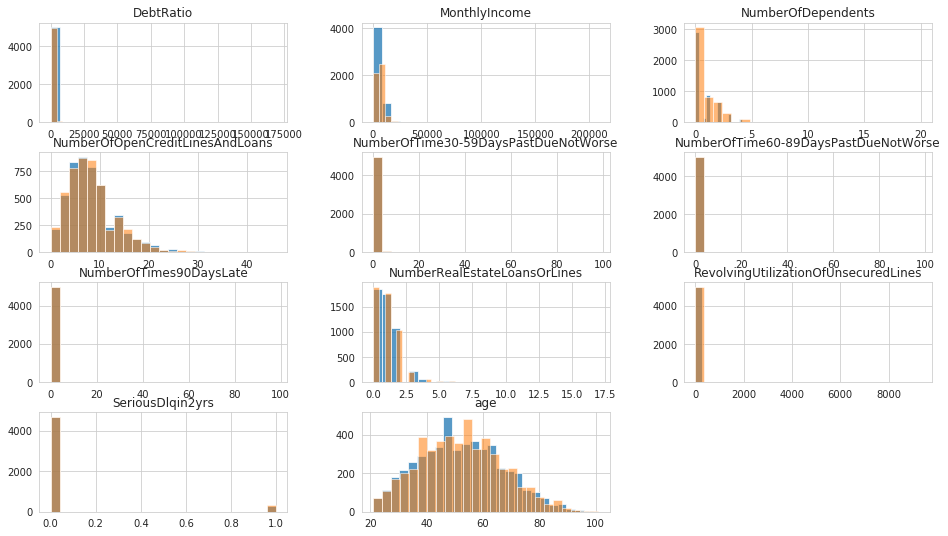

In [0]:
axes = training_data.hist(figsize=(16, 9), bins=25, alpha=0.75) # that will plot training data histograms

for plot in axes.flat: # that will draw test data on top of training histograms
    column = plot.title.get_text()
    if column:
        test_data[column].hist(ax=plot, bins=25, alpha=0.55)

Pay attention to **SeriousDlqin2yrs** -- 90 days past due delinquency or worse in the last 2 years. We see that most of the borrowers pay in time.

In [0]:
# The data set is imbalanced: typically people return credits
training_data["SeriousDlqin2yrs"].value_counts()

0    4696
1     305
Name: SeriousDlqin2yrs, dtype: int64

# Classification algorithms

First of all, load data for learning as pairs $(X, y)$, where $X = (x_i)_{i=1}^n$ -- input features,
and $y=(y_i)_{i=1}^n$ corresponding labels.

In [0]:
training_X = training_data.drop("SeriousDlqin2yrs", axis=1)
training_y = training_data["SeriousDlqin2yrs"]

test_X = test_data.drop("SeriousDlqin2yrs", axis=1)
test_y = test_data["SeriousDlqin2yrs"]

Construct calssification algorithms and train them.

In [0]:
# Construct Decision Tree model

decision_tree = DecisionTreeClassifier()
decision_tree.fit(training_X, training_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
# Construct k Nearest Neighbors model

knn = KNeighborsClassifier()
knn.fit(training_X, training_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [0]:
print("Training accuracy:")
print("\tDT accuracy:\t%.2f%%" % (100 * decision_tree.score(training_X, training_y)))
print("\tkNN accuracy:\t%.2f%%" % (100 * knn.score(training_X, training_y)))
print("\tNumber of '0' labels:\t%.2f%%" % (100 - 100 * np.mean(training_y)))
print()

print("Test accuracy:")
print("\tDT accuarcy:\t%.2f%%" % (100 * decision_tree.score(test_X, test_y)))
print("\tkNN accuarcy:\t%.2f%%" % (100 * knn.score(test_X, test_y)))
print("\tNumber of '0' labels:\t%.2f%%" % (100 - 100 * np.mean(test_y)))

Training accuracy:
	DT accuracy:	100.00%
	kNN accuracy:	94.10%
	Number of '0' labels:	93.90%

Test accuracy:
	DT accuarcy:	89.82%
	kNN accuarcy:	93.08%
	Number of '0' labels:	93.30%


In [0]:
test_predictions_dt = decision_tree.predict(test_X)
test_probabilities_dt = decision_tree.predict_proba(test_X)[:, 1]

training_predictions_dt = decision_tree.predict(training_X)
training_probabilities_dt = decision_tree.predict_proba(training_X)[:, 1]

In [0]:
test_predictions_knn = knn.predict(test_X)
test_probabilities_knn = knn.predict_proba(test_X)[:, 1]

training_predictions_knn = knn.predict(training_X)
training_probabilities_knn = knn.predict_proba(training_X)[:, 1]

# Classification quality measures

## Confusion matrix

Confusion matrix is table layout that allows visualization of the performance of an algorithm. Rows of this matrix correspond to actual classes of the test set, columns correspond to predicted labels. There are 4 types of elements if predictions are given:
* True Positive
* False Negative
* False Positive
* True Negative

| Variable | Predicted True | Predicted False |
| ------------- |-------------|-----|
| Actual True  | TP | FN | 
| Actual False | FP | TN |


In [0]:
confusion_dt = pd.DataFrame(confusion_matrix(test_y, test_predictions_dt))

confusion_knn = pd.DataFrame(confusion_matrix(test_y, test_predictions_knn))

print('Confusion for Decision Tree:')
print(confusion_dt)
print('Confusion for kNN:')
print(confusion_knn)

Confusion for Decision Tree:
      0    1
0  4410  256
1   253   82
Confusion for kNN:
      0   1
0  4651  15
1   331   4


If we want to compare metrics on different data, we can use instead True Positive Rate and False Positive Rate:
* False Positive Rate is $\frac{FP}{FP + TN}$
* True  Positive Rate is $\frac{TP}{TP + FN}$

## ROC curve

ROC stands for *Receiver Operating Characteristic*. This curve shows True Positive Rate (**TPR**) against False Positive Rate (**FPR**) as classifier's discrimination threshold is varied

Remember that classifiers are usually constructed based on some function
$f(x) \in [0, 1]$ and threshold $\tau$:
$$ \text{Classifier}\bigl(\text{object}\bigr)
    = \begin{cases}
    1 & \text{if}\, f(\text{object}) \geq \tau\,,\\
    0 & \text{else}\,.
    \end{cases}
    $$
    
**roc_curve** function from *scikit-learn* allows to easily obtain ROC curve points and **threshold** values.

Detailed description of ROC-AUC by Alexander Dyakonov 
https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/

In [0]:
false_positive_rates_dt, true_positive_rates_dt, threshold_dt = roc_curve(test_y, test_probabilities_dt)

false_positive_rates_knn, true_positive_rates_knn, threshold_knn = roc_curve(test_y, test_probabilities_knn)

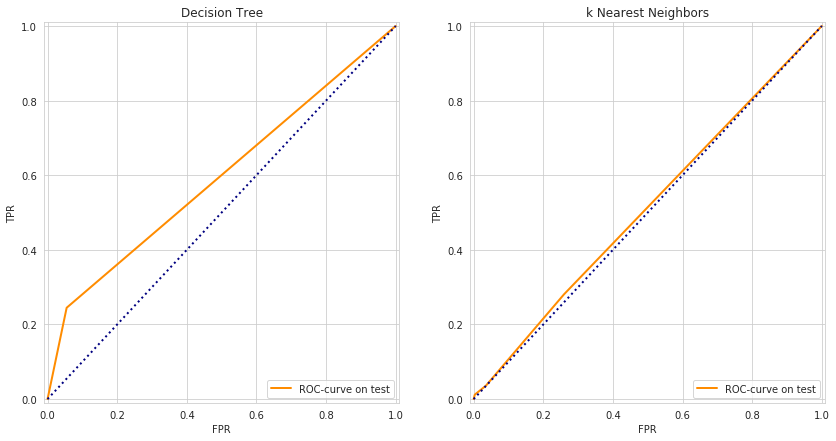

In [0]:
# create plot
fig = plt.figure(figsize=(14, 7))

# specify parameters for the first curve
plot_1 = fig.add_subplot(121,
                       xlabel="FPR", xlim=(-.01, 1.01),
                       ylabel="TPR", ylim=(-.01, 1.01), title = 'Decision Tree')

# draw the first curve
plot_1.plot(false_positive_rates_dt, true_positive_rates_dt,
          color='darkorange', lw=2, label = 'ROC-curve on test')
plot_1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':')
plt.legend(loc="lower right")

# specify parameters for the second curve
plot_2 = fig.add_subplot(122,
                       xlabel="FPR", xlim=(-.01, 1.01),
                       ylabel="TPR", ylim=(-.01, 1.01), title = 'k Nearest Neighbors')

# draw the second curve
plot_2.plot(false_positive_rates_knn, true_positive_rates_knn,
          color='darkorange', lw=2, label = 'ROC-curve on test')
plot_2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':')
plt.legend(loc="lower right")

plt.show()

The closer **ROC** curve to the **upper left** corner, the better classification is.

Despite being a good visual representation we usually need a number to make conclusions about calssification quality. In case of ROC curve this number is Area Under the Curve (**ROC-AUC**). 

*scikit-learn* has a special function **auc(...)**:

In [0]:
roc_auc_dt = auc(false_positive_rates_dt, true_positive_rates_dt)
roc_auc_knn = auc(false_positive_rates_knn, true_positive_rates_knn)

print("DT ROC-AUC on test data:", roc_auc_dt) 
print("kNN ROC-AUC on test data:", roc_auc_knn) 

DT ROC-AUC on test data: 0.5949555693457275
kNN ROC-AUC on test data: 0.5105027797147994


For the trainibng set ROC curve and ROC-AUC look much better.

In [0]:
training_false_positive_rates_dt, training_true_positive_rates_dt, _ = roc_curve(training_y, training_probabilities_dt)
training_false_positive_rates_knn, training_true_positive_rates_knn, _ = roc_curve(training_y, training_probabilities_knn)

training_roc_auc_dt = auc(training_false_positive_rates_dt, training_true_positive_rates_dt)
training_roc_auc_knn = auc(training_false_positive_rates_knn, training_true_positive_rates_knn)

print("DT ROC-AUC on training data:", training_roc_auc_dt) 
print("kNN ROC-AUC on training data:", training_roc_auc_knn) 

DT ROC-AUC on training data: 1.0
kNN ROC-AUC on training data: 0.9093846873516351


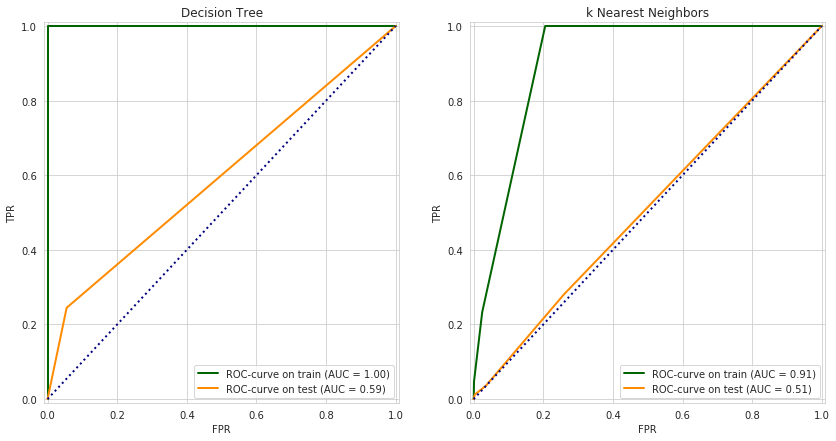

In [0]:
fig = plt.figure(figsize=(14, 7))

plot_1 = fig.add_subplot(121,
                       xlabel="FPR", xlim=(-.01, 1.01),
                       ylabel="TPR", ylim=(-.01, 1.01), title = 'Decision Tree')

# draw the first curve
plot_1.plot(training_false_positive_rates_dt, training_true_positive_rates_dt,
          color='darkgreen', lw=2, label = 'ROC-curve on train (AUC = %0.2f)' % training_roc_auc_dt)
plot_1.plot(false_positive_rates_dt, true_positive_rates_dt,
          color='darkorange', lw=2, label = 'ROC-curve on test (AUC = %0.2f)' % roc_auc_dt)
plot_1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':')
plt.legend(loc="lower right")

# specify parameters for the second curve
plot_2 = fig.add_subplot(122,
                       xlabel="FPR", xlim=(-.01, 1.01),
                       ylabel="TPR", ylim=(-.01, 1.01), title = 'k Nearest Neighbors')

# draw the second curve
plot_2.plot(training_false_positive_rates_knn, training_true_positive_rates_knn,
          color='darkgreen', lw=2, label = 'ROC-curve on train (AUC = %0.2f)' % training_roc_auc_knn)
plot_2.plot(false_positive_rates_knn, true_positive_rates_knn,
          color='darkorange', lw=2, label = 'ROC-curve on test (AUC = %0.2f)' % roc_auc_knn)
plot_2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':')
plt.legend(loc="lower right")

plt.show()

Another ROC-AUC visualization http://www.navan.name/roc/

Area under ROC-curve = probalbity of pairs of objects from different classed beibg classified correctly.

![alt text](https://alexanderdyakonov.files.wordpress.com/2017/07/eq.png)

## Precision and Recall

Precision and Recall are two other measures for evaluation of classification quality. Both of the metrics are calculated based on **confusion matrix**.

<img src="https://github.com/IlyaTrofimov/ML2020-Skoltech/blob/master/figures/precision_recall.png?raw=1">

Note that Recall equals to True Positive Rate.

Although "accuracy" and "precision" have very similar meanings, they are completely different metrics. Look how Precision and Recall are evaluated for k Nearest Neighbors classifier:

In [0]:
confusion = confusion_matrix(test_y, test_predictions_knn)

In [0]:
TN, FP = confusion[0, 0], confusion[0, 1]

FN, TP = confusion[1, 0], confusion[1, 1]

**Recall** of a classifier is equal to True Positive Rate **TPR** ($\frac{TP}{TP + FN}$). This value may be interpreted as a sensitivity of a classifier to the objects with label `1`. If it is close to $100\%$, then a classifier rarely "miss" the object of class `1`.

In [0]:
recall = TP / (TP + FN)

print("Recall: %.2f%%" % (100 * recall))

Recall: 1.19%


**Precision** -- is a fraction $\frac{TP}{TP + FP}$. If this value is large, then a classifier assigns label `1` to objects with actual label `0` rarely.

See how it is different to Accuracy = $\frac{TP + TN}{TP + TN + FP + FN}$

In [0]:
precision = TP / (TP + FP)

print("Precision: %.2f%%" % (100 * precision))

Precision: 21.05%


A classifier with large Recall but small Precision produces many false positive predictions and tends to assign many `1` labels.

Vice versa, if a classifier has small Recall but large Precision, then it detects class `1` accurately, but misses many objects (many false negative predictions).

### Precision-Recall curve

In **precision-recall** space we may construct a curve similar to **ROC** curve in **FPR-TPR** space. PR curve also depicts the dependecy of Precision and Recall on threshold. *scikit* has the corresponding function: **precision_recall_curve(...)**.

Let's calculate PR curve points.

Note that unlike ROC curve, we cannot use interpolation for calculation of area under the curve. This may lead to larger values of the metric, which is not good. In this case we need to use **average_precision_score()** function instead of **auc()** function.

In [0]:
# generate values for Precision-Recall curve
precision_dt, recall_dt, _ = precision_recall_curve(test_y, test_probabilities_dt)
precision_knn, recall_knn, _ = precision_recall_curve(test_y, test_probabilities_knn)

# calculate value under Precision-Recall curve
pr_auc_dt = average_precision_score(test_y, test_probabilities_dt)
pr_auc_knn = average_precision_score(test_y, test_probabilities_knn)

print("DT PR-AUC on test data:", pr_auc_dt) 
print("kNN PR-AUC on test data:", pr_auc_knn)

DT PR-AUC on test data: 0.10997343761840231
kNN PR-AUC on test data: 0.06997723581835391


In [0]:
# generate values for training Precision Recall curve
training_precision_dt, training_recall_dt, _ = precision_recall_curve(training_y, training_probabilities_dt)
training_precision_knn, training_recall_knn, _ = precision_recall_curve(training_y, training_probabilities_knn)

# TODO calculate value under precision-recall curve
training_pr_auc_dt = average_precision_score(training_y, training_probabilities_dt)
training_pr_auc_knn = average_precision_score(training_y, training_probabilities_knn)

print("DT PR-AUC on training data:", training_pr_auc_dt) 
print("kNN PR-AUC on training data:", training_pr_auc_knn) 

DT PR-AUC on training data: 1.0
kNN PR-AUC on training data: 0.291291159995799


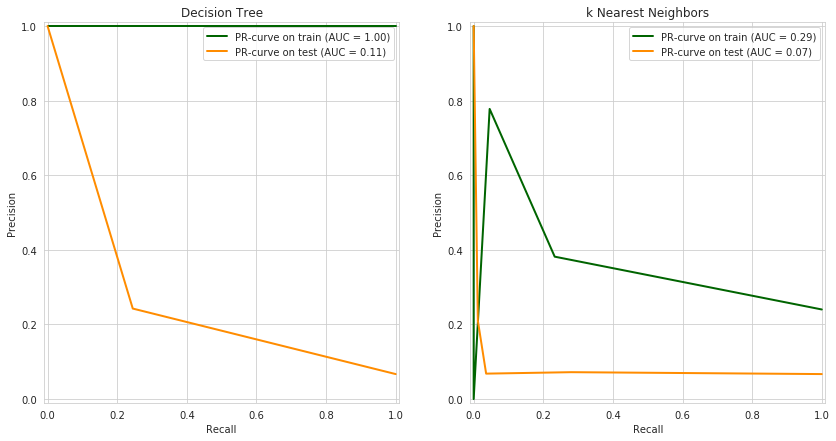

In [0]:
fig = plt.figure(figsize=(14, 7))

plot_1 = fig.add_subplot(121,
                       xlabel="Recall", xlim=(-.01, 1.01),
                       ylabel="Precision", ylim=(-.01, 1.01), title = 'Decision Tree')

plot_1.plot(training_recall_dt, training_precision_dt,
          color='darkgreen', lw=2, label = 'PR-curve on train (AUC = %0.2f)' % training_pr_auc_dt)
plot_1.plot(recall_dt, precision_dt,
          color='darkorange', lw=2, label = 'PR-curve on test (AUC = %0.2f)' % pr_auc_dt)
plt.legend(loc="upper right")


plot_2 = fig.add_subplot(122,
                       xlabel="Recall", xlim=(-.01, 1.01),
                       ylabel="Precision", ylim=(-.01, 1.01), title = 'k Nearest Neighbors')

plot_2.plot(training_recall_knn, training_precision_knn,
          color='darkgreen', lw=2, label = 'PR-curve on train (AUC = %0.2f)' % training_pr_auc_knn)
plot_2.plot(recall_knn, precision_knn,
          color='darkorange', lw=2, label = 'PR-curve on test (AUC = %0.2f)' % pr_auc_knn)
plt.legend(loc="upper right")

plt.show()

The closer **PR** curve to the **upper right** corner, the better classification is.

Large AUC value means that Precision and Recall are also large. That means that classifier makes small number of both False Positives and False Negatives.

## F1 score

This metric allows to take into account a different cost for False Positive Errors and False Negative Errors.

General $F_\beta$ score is defined as follows:
$$
F_\beta = (1 + \beta^2) \frac{Precision \cdot Recall}{\beta^2 Precision + Recall} = \frac{1 + \beta^2}{\frac{\beta^2}{Recall} + \frac{1}{Precision}}= \frac{\beta + \beta^{-1}}{\beta\frac{1}{\text{Recall}} + \beta^{-1}\frac{1}{\text{Precision}}}
    \,.
$$

Most commonly used is $F_1$ score:
$$
F_1 = \frac{Precision \cdot Recall}{Precision + Recall}
$$

Harmonic mean is used in order to make metric value very small when Precision or Recall is close to zero. Note that $F_1$ score doesn't describe how classifier works for True Negative results (**TN**).

In [0]:
print("DT F1 score on training data", f1_score(training_y, training_predictions_dt))
print("kNN F1 score on training data", f1_score(training_y, training_predictions_knn))

print("DT F1 score on test data", f1_score(test_y, test_predictions_dt))
print("kNN F1 score on test data", f1_score(test_y, test_predictions_knn))

DT F1 score on training data 1.0
kNN F1 score on training data 0.0866873065015
DT F1 score on test data 0.246290801187
kNN F1 score on test data 0.0225988700565


$F_1$ score is good for imbalanced classification, when a number of class `1` objects is **much** bigger than class `0` objects.

Let's compare **accuracy** and $F_1$ score of our classifiers with *random* classifier, which works as follows:

* estimate probability $\hat{p}$ of class `1` on training data (frequency of class `1` objects);
* for every test object predict randomly:
    * label `1` with probability $\hat{p}$,
    * label `0` with probability $1 - \hat{p}$.

In [0]:
training_prob = sum(training_y) / len(training_y)
random_predictions = np.random.binomial(1, training_prob, len(test_y))

In [0]:
print("Decision Tree accuracy\t\t", accuracy_score(test_y, test_predictions_dt))
print("kNN accuracy\t\t\t", accuracy_score(test_y, test_predictions_knn))
print("Random classifier accuracy\t", accuracy_score(test_y, random_predictions))
print('---')
print("Decision Tree F1 score\t\t", f1_score(test_y, test_predictions_dt))
print("kNN F1 score\t\t\t", f1_score(test_y, test_predictions_knn))
print("FRandom classifier F1 score\t", f1_score(test_y, random_predictions))

Decision Tree accuracy		 0.898420315937
kNN accuracy			 0.930813837233
Random classifier accuracy	 0.876824635073
---
Decision Tree F1 score		 0.246290801187
kNN F1 score			 0.0225988700565
FRandom classifier F1 score	 0.0523076923077


# Exercise 1

We have seen how some of classifiers work for this dataset. Now, try it yourself with Logistic Regression.

* Fisrt, **import** **LogisticRegression()** function and train it on training data.
* Then, calculate **ROC AUC**, **PR AUC** and **F1 score** on test data.
* Try to change parameters to improve results.

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [0]:
# import function here


In [0]:
logistic_regression = 


In [0]:
# put your code here


# Cross-validation technique

In many cases test sample is not available or we have a small dataset, and we have only one sample: a training one. The most popular approach in this case is **cross-validation**.

The most common way is $k$-fold cross-validation. The idea is to divide training sample into $k$ blocks, one of them is treated as an artificial test sample and other $k-1$ are used for training.

*scikit* has several functions for dividing data into folds and for performing automated cross-validation. One of those functions is **GridSearchCV()**.

<img src="https://github.com/IlyaTrofimov/ML2020-Skoltech/blob/master/figures/5-fold-cv.png?raw=1">

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
parameters_knn = {'n_neighbors': [5, 10, 15, 20]}
knn_cv = GridSearchCV(knn, param_grid = parameters_knn)
knn_cv.fit(training_X, training_y)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
knn_cv.best_params_

{'n_neighbors': 10}

In [0]:
predictions_knn_cv = knn_cv.predict(test_X)
probabilities_knn_cv = knn_cv.predict_proba(test_X)[:,1]

In [0]:
false_positive_rates_knn_cv, true_positive_rates_knn_cv, _ = roc_curve(test_y, probabilities_knn_cv)
roc_auc_knn_cv = auc(false_positive_rates_knn_cv, true_positive_rates_knn_cv)

In [0]:
precision_knn_cv, recall_knn_cv, _ = precision_recall_curve(test_y, probabilities_knn_cv)
pr_auc_knn_cv = average_precision_score(test_y, probabilities_knn_cv)

In [0]:
f1_knn_cv = f1_score(test_y, predictions_knn_cv)

/Users/albertmatveev/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
print('ROC AUC: ', roc_auc_knn_cv)
print('PR AUC: ', pr_auc_knn_cv)
print('F1_score: ', f1_knn_cv)

ROC AUC:  0.549520827069
PR AUC:  0.0797195956759
F1_score:  0.0


In [0]:
pd.DataFrame(confusion_matrix(test_y, predictions_knn_cv))

,0,1
0,4666,0
1,335,0


# Exercise 2

Now we know how to perform cross-validation. Try it yourself with Decision Tree.

* Using **GridSearchCV** choose parameter **min_samples_leaf**. Try several values from 1 to 100.
* Use **five**-fold cross-validation and **roc_auc** scoring. See the chosen parameters.
* Evaluate quality metrics and look how they changed. Try to make some plots.

http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [0]:
parameters_dt = 
dt_cv = 

In [0]:
print('ROC AUC: ', roc_auc_dt_cv)
print('PR AUC: ', pr_auc_dt_cv)
print('F1_score: ', f1_dt_cv)

In [0]:
# generate plots here

# Multiclass classification

Let's have a look how multiclass tasks are treated.

In [0]:
# import some modules

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.base import clone

from sklearn.linear_model import LogisticRegression

In [0]:
# for ZIP-files
import zipfile

## Load data

We will use data from Kaggle contest *"Otto Group
Product Classification Challenge"*, which was created to predict class of an item by several features.з

https://www.kaggle.com/c/otto-group-product-classification-challenge

Data are in ZIP, but we can load them easily

In [0]:
with zipfile.ZipFile('data/train.csv.zip') as archive:
    dataset = pd.read_csv(archive.open('train.csv'), index_col='id')

Data consist of the following:
* **id** -- anonymized identifier;
* **feat_1, ..., feat_93** -- features;
* **target** -- actual class of an item.

Number of objects for every class in **target**

In [0]:
dataset['target'].value_counts()

Class_2    16122
Class_6    14135
Class_8     8464
Class_3     8004
Class_9     4955
Class_7     2839
Class_5     2739
Class_4     2691
Class_1     1929
Name: target, dtype: int64

Let's see random data slice

In [0]:
dataset.describe().T.sample(10, random_state=42)

,count,mean,std,min,25%,50%,75%,max
feat_41,61878.0,0.303468,1.085672,0.0,0.0,0.0,0.0,36.0
feat_23,61878.0,0.142522,0.782979,0.0,0.0,0.0,0.0,64.0
feat_56,61878.0,0.303775,1.925806,0.0,0.0,0.0,0.0,62.0
feat_73,61878.0,0.591050,5.783233,0.0,0.0,0.0,0.0,352.0
feat_1,61878.0,0.386680,1.525330,0.0,0.0,0.0,0.0,61.0
feat_27,61878.0,0.696613,2.873222,0.0,0.0,0.0,0.0,123.0
feat_40,61878.0,1.653059,3.299798,0.0,0.0,0.0,2.0,41.0
feat_68,61878.0,0.392902,1.761054,0.0,0.0,0.0,0.0,109.0
feat_11,61878.0,1.252869,3.042333,0.0,0.0,0.0,1.0,38.0
feat_45,61878.0,0.238130,2.587131,0.0,0.0,0.0,0.0,80.0


Divide data into input and output, transform labels from strings to numbers. **LabelEncoder** allows us to perform that transform nad obtain numbers from $0$ to $K-1$, where $K$ is the number of classes.

In [0]:
X = np.asarray(dataset.drop('target', axis=1), dtype=float)
target = dataset['target']

label_encoder = LabelEncoder().fit(target)
y = label_encoder.transform(target)

Split data into training sample and test sample

In [0]:
split = train_test_split(X, y, test_size=0.5,
                         random_state=42, stratify=y)
train_X, test_X, train_y, test_y = split